# **AUTOENCODERS**

In [ ]:
# Google colab
import sys
if 'google.colab' in sys.modules:
  from google.colab import output
  output.enable_custom_widget_manager()
  import subprocess
  try:
    subprocess.run(["conda", "-V"], check=True)
  except FileNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "condacolab"])
    import condacolab
    condacolab.install()
    subprocess.check_call(["conda", "env", "update", "-n", "base", "-f", "environment.yaml"])
    print("Environment installed")
    print("Please ignore this error message: 'Your session crashed for an unknown reason.'")


In [8]:
# Check if running in Google Colab
import numpy as np
import mdtraj as md
import nglview as nv
import biobb_pytorch
from biobb_pytorch.mdae import plots
import requests
from pathlib import Path

In [2]:
# Global variables
traj_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/A0001/trajectory?format=xtc&frames=1%3A10000%3A10&selection=backbone%20and%20_C"
pdb_URL = "https://mmb-dev.mddbr.eu/api/rest/v1/projects/A0001/structure?selection=backbone%20and%20_C"
traj_path = "trajs/1apq.xtc"
structure_path = "trajs/1apq.pdb"
Path(traj_path).parent.mkdir(parents=True, exist_ok=True)

# **AutoEncoders for Anomaly Detection**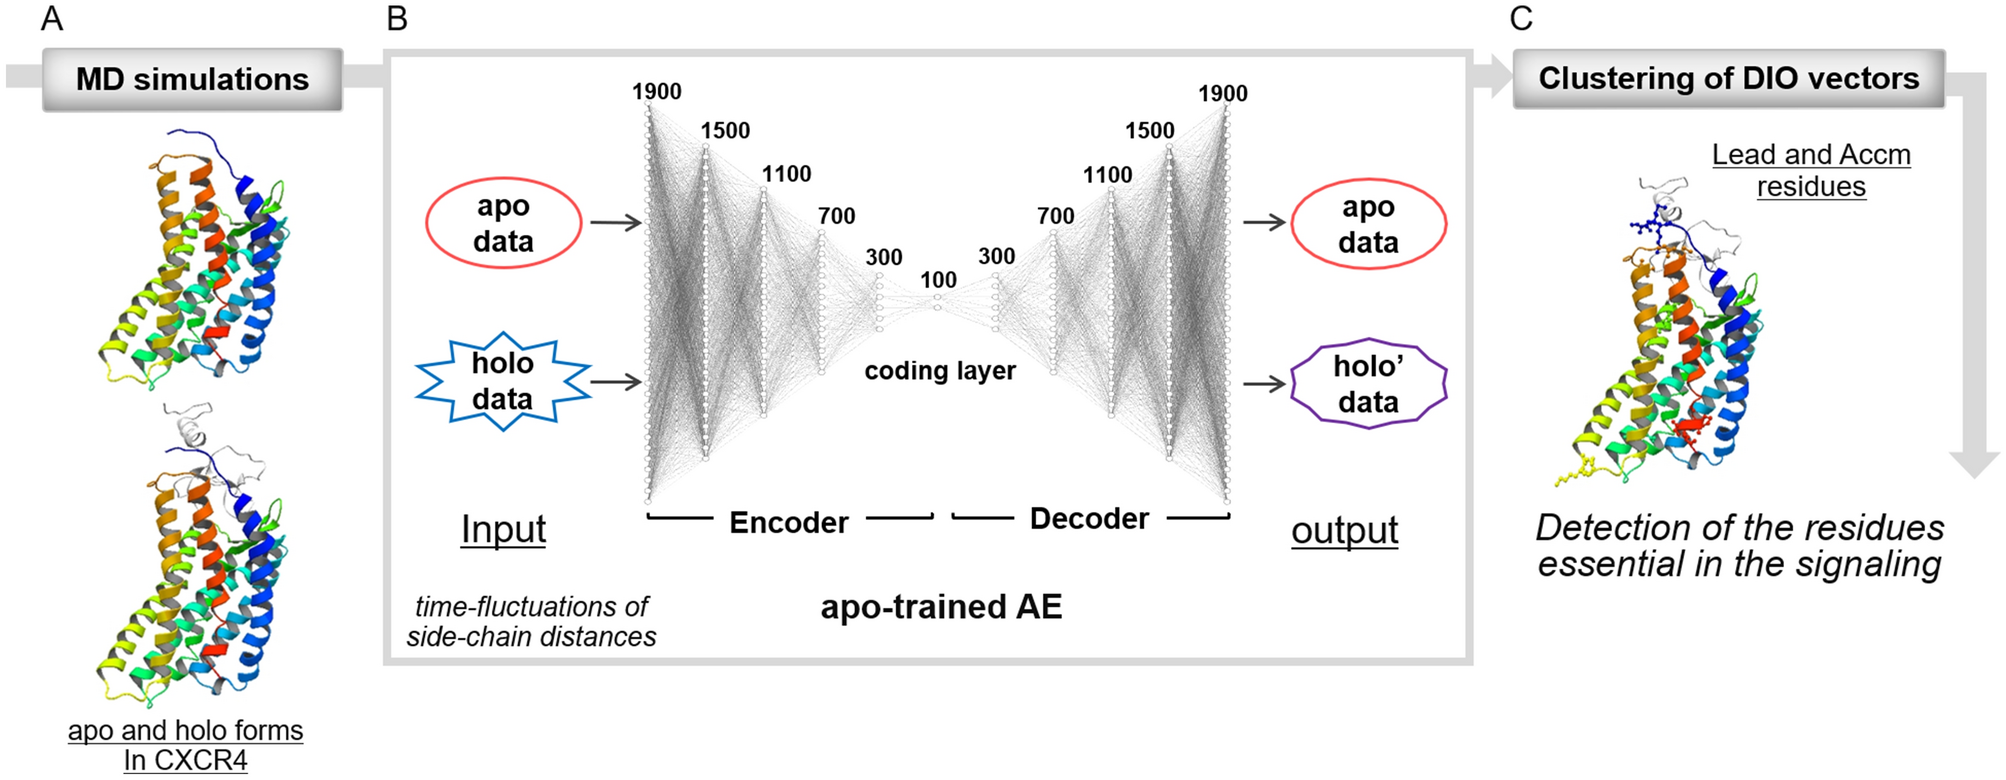

Tsuchiya, Y., Taneishi, K. & Yonezawa, Y. Autoencoder-based detection of the residues involved in G protein-coupled receptor signaling. Sci Rep 11, 19867 (2021). https://doi.org/10.1038/s41598-021-99019-z

#### **ARTICLE**

The described study involves the use of a multilayer AutoEncoder (AE) for feature extraction and pattern recognition in the context of protein dynamics. Here's a breakdown of the key points and processes described:

**Multilayer Pyramidal AutoEncoder Structure**

* AutoEncoder (AE): An unsupervised neural network used for dimensionality reduction, feature extraction, and pattern recognition.
* Architecture: The AE has 13 fully connected layers.
  * Encoder: 6 layers, with node counts increasing from 400 to 1900 in increments of 300 nodes.
  * Coding Layer: The central layer with 100 nodes.
  * Decoder: Mirrors the encoder with 6 layers.

* Function: The AE is trained to reconstruct the input data. It learns to minimize the mean squared error (MSE) between the original input and the reconstructed output.
* Feature Extraction: If the reconstruction error is minimized well, the AE effectively extracts features of the dynamics of residue pairs.

**Data Preparation**

* Input Data: The input to the AE is the vector of side-chain distances between residues.
* Distance Calculation: Distances are calculated between the centers of mass of the side-chain atoms (excluding hydrogen) for pairs of residues.
* Time Increments: Distances are measured from 50.5 ns to 1000 ns in 0.5 ns increments (1900 steps) within a trajectory from molecular dynamics (MD) simulations.
* Vector Representation: Each pair of residues is represented as a 1900-dimensional vector based on the distance data.

**Training the AutoEncoder**
* Data Split: The data is split into 80% for training and 20% for validation.
* Two Separate AEs: Two different AEs are trained, one with apo1 data and the other with apo2 data.
* Optimization: The Adam optimizer is used with a learning rate of 0.00001.
* Batch Size: The training data are divided into batches, each containing vectors for 100 residue pairs.
* Epochs: Training is conducted for 100,000 epochs and stops when the validation loss decreases.
* Hyperparameter Selection: The choice of hyperparameters (like learning rate, batch size) is based on achieving the best performance in terms of loss and accuracy.

Rate of Node Steps:

$$ \delta = \frac{{{input_{dim}} - {latent_{dim}}}}{{{n_{layers} + 1}}} $$


Loss Function:

$$ \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

where,
* $n$ is the number of samples.
* $y_i$ is the actual value for the ii-th sample.
* $\hat{y}_i$ is the predicted value for the ii-th sample



**Hyperparameters:**

* *partition* : Percentage selected of data as the training partition. Default = 0.8.

* *batch_size* :  Number of samples of the dataset per batch toload. It is the number of training examples utilized in one iteration. Default = 1.

* *latent_dim* : Number of dimensions of the latent space. It is a representation of compressed data in a low-dimensional space. Default = 2.

* *number_layers* : Number of layers in both encoder and decoder neural networks, excluding the layer of the latent space and the output layer. Default = 5.

* *learning_rate* : Learning rate used for the Adam optimizer. It is the parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of the loss function. Default = 0.0001

* *epochs* : Number of epochs required for training the model. It is the number times that the learning algorithm will work through the entire training dataset. Default = 100.

* *normalize* : Normalize the input data. Default = True.


In [3]:
# Downloading trajectory and structure

req = requests.get(traj_URL, allow_redirects=True)
open(traj_path, 'wb').write(req.content)
req = requests.get(pdb_URL, allow_redirects=True)
open(structure_path, 'wb').write(req.content)

# Load trajectory
traj = md.load(traj_path, top=structure_path)

In [4]:
# Show trajectory
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=999)

**Data Setup/Featurization**

In [5]:
# Input files
input_train_npy_path = "trajs/1apq.npy" # Training data
np.save(input_train_npy_path, traj.xyz) # Save the trajectory as a numpy array
input_model_pth_path = "1apq_parameter_epochs_100.pth" # Model name
output_train_data_npz_path = "train_data.npz"

# input_data_npy_path = "WT_holo_md_b25_CA_ChainsA_DRY_imagedFit_0_347.npy" # Data to predict

# Model parameters
nlayers = 5
epochs = 100
lr = 0.0001
partition = 0.8
latent_dim = 2

**Train Model**

In [6]:
# Output files
output_model_pth_path = "model.pth"
output_train_data_npz_path = "train_data.npz"
output_performance_npz_path = "performance.npz"

prop = {
    "latent_dimensions": latent_dim,
    "num_layers": nlayers,
    "num_epochs": epochs,
    "lr": lr,
    "partition": partition,
    "log_interval": 1
    }
biobb_pytorch.mdae.train_mdae.trainMDAE(input_train_npy_path=input_train_npy_path,
                                        output_model_pth_path=output_model_pth_path,
                                        output_train_data_npz_path=output_train_data_npz_path,
                                        output_performance_npz_path=output_performance_npz_path,
                                        properties=prop)

2024-05-02 12:36:54,116 [MainThread  ] [INFO ]  Executing biobb_pytorch.mdae.train_mdae Version: 4.1.0
2024-05-02 12:36:54,121 [MainThread  ] [INFO ]  Copy: trajs/1apq.npy to /Users/pau/projects/mdautoencoder/autoencoder_wf/41245fbc-05da-4956-9c7b-e3c9300d3f52
2024-05-02 12:36:54,123 [MainThread  ] [INFO ]  Start Training:
2024-05-02 12:36:54,123 [MainThread  ] [INFO ]    Device: cpu
2024-05-02 12:36:54,126 [MainThread  ] [INFO ]    Number of atoms: 510
2024-05-02 12:36:54,127 [MainThread  ] [INFO ]    Number of frames for training: 800    Total number of frames: 1000
2024-05-02 12:36:54,127 [MainThread  ] [INFO ]    Number of epochs: 100
2024-05-02 12:36:54,128 [MainThread  ] [INFO ]    Partition: 0.8
2024-05-02 12:36:54,129 [MainThread  ] [INFO ]    Batch size: 1
2024-05-02 12:36:54,130 [MainThread  ] [INFO ]    Learning rate: 0.0001
2024-05-02 12:36:54,131 [MainThread  ] [INFO ]    Number of layers: 5
2024-05-02 12:36:54,131 [MainThread  ] [INFO ]    Latent dimensions: 2
2024-05-02 

0

**Plot Loss vs Epochs**

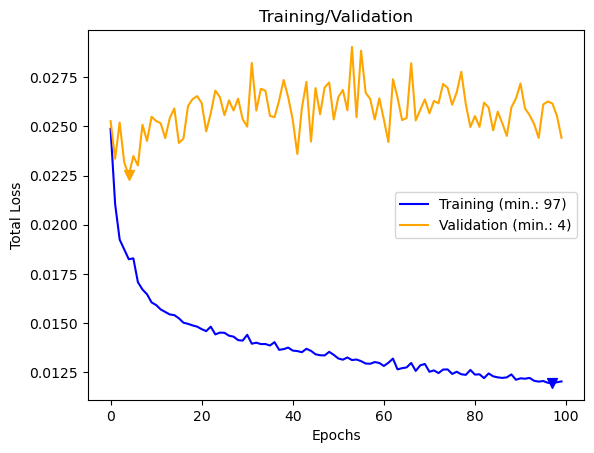

In [9]:
plots.plot_loss(output_train_data_npz_path=output_train_data_npz_path)

**Apply Model to Train Data**

In [10]:
# If you want to apply the trained model uncomment the following line
input_model_pth_path = output_model_pth_path

# Output files
output_reconstructed_train_npy_path = "reconstructed_train_data.npy"
output_train_latent_space_npy_path = "train_latent_space.npy"

prop = {
    "latent_dimensions": latent_dim,
    "num_layers": nlayers
}

biobb_pytorch.mdae.apply_mdae.applyMDAE(input_data_npy_path=input_train_npy_path,
                                        input_model_pth_path=input_model_pth_path,
                                        output_reconstructed_data_npy_path=output_reconstructed_train_npy_path,
                                        output_latent_space_npy_path=output_train_latent_space_npy_path,
                                        properties=prop)

2024-05-02 15:34:08,774 [MainThread  ] [INFO ]  Executing biobb_pytorch.mdae.apply_mdae Version: 4.1.0
2024-05-02 15:34:08,779 [MainThread  ] [INFO ]  Copy: trajs/1apq.npy to /Users/pau/projects/mdautoencoder/autoencoder_wf/9c8b5282-89d5-4ed5-a6ac-47c57a496a9d
2024-05-02 15:34:08,854 [MainThread  ] [INFO ]  Copy: model.pth to /Users/pau/projects/mdautoencoder/autoencoder_wf/9c8b5282-89d5-4ed5-a6ac-47c57a496a9d
2024-05-02 15:34:08,856 [MainThread  ] [INFO ]  Applying MDAE model reducing dimensionality from 1530 to 2 and reconstructing.
2024-05-02 15:34:10,516 [MainThread  ] [INFO ]  Saving reconstructed data to /Users/pau/projects/mdautoencoder/autoencoder_wf/9c8b5282-89d5-4ed5-a6ac-47c57a496a9d/reconstructed_train_data.npy
2024-05-02 15:34:10,540 [MainThread  ] [INFO ]  Saving latent space to train_latent_space.npy
2024-05-02 15:34:10,546 [MainThread  ] [INFO ]  Removed: []


0

**Train Trajectory Reconstruction RMSD**

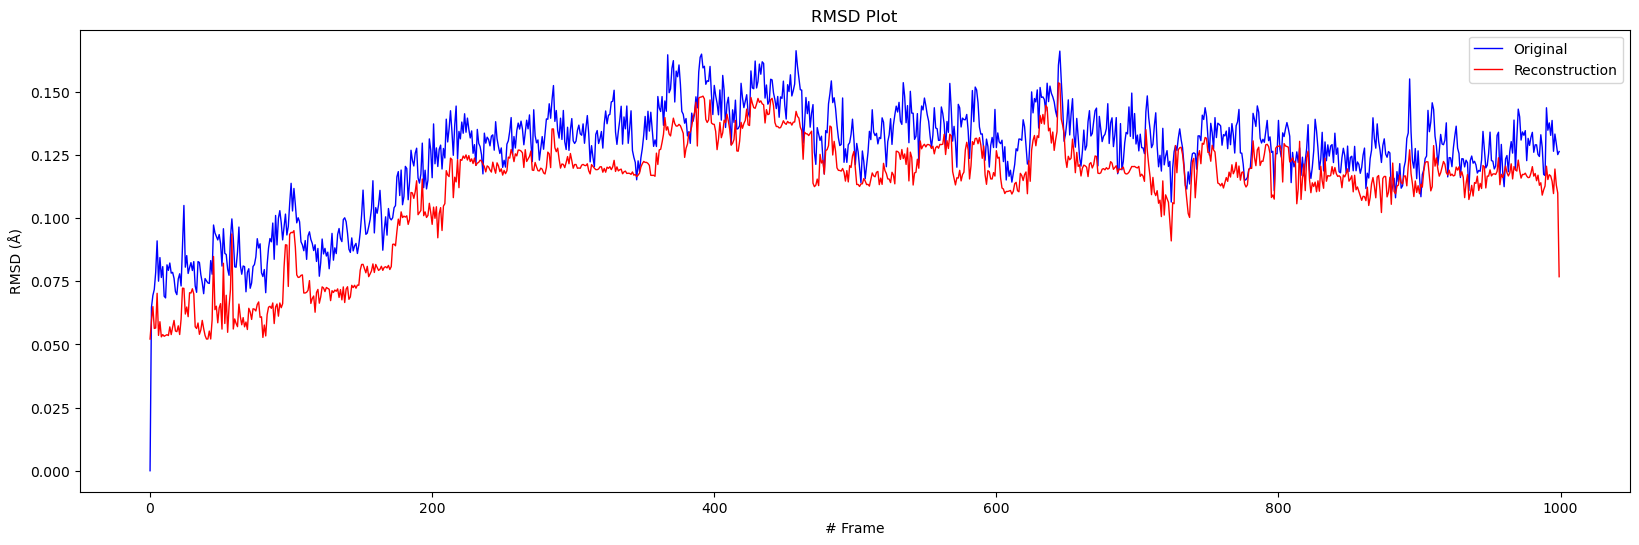

In [11]:
biobb_pytorch.mdae.plots.plot_rmsd(traj_file_npy_path=input_train_npy_path, output_reconstructed_traj_npy_path=output_reconstructed_train_npy_path)

**Train Latent Space Representation**

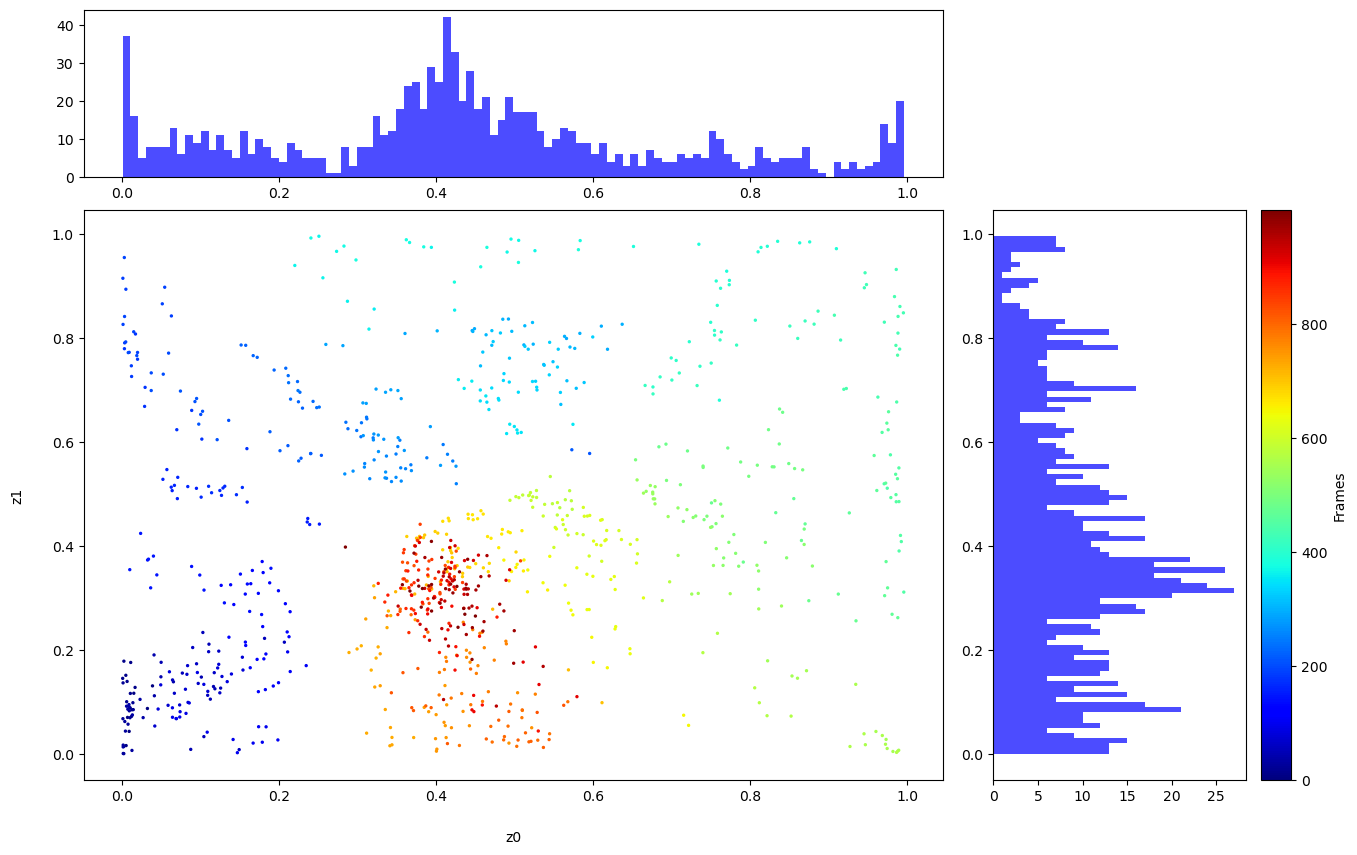

In [13]:
# Latent Space Representation
plots.plot_latent_space(latent_space_npy_path=output_train_latent_space_npy_path)

**Train RMSF**

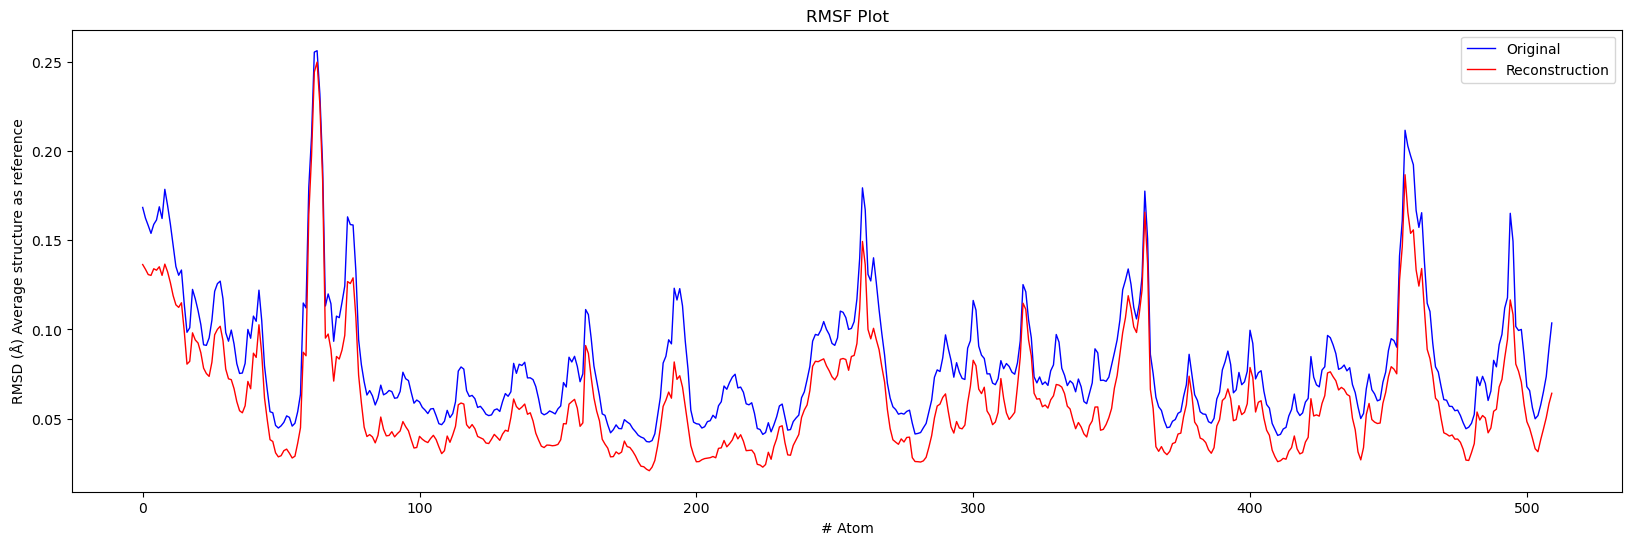

In [24]:
plot_rmsf(original_traj_npy_file=input_train_npy_path, mutated_reconstructed_traj_npy_file=output_reconstructed_train_npy_path)

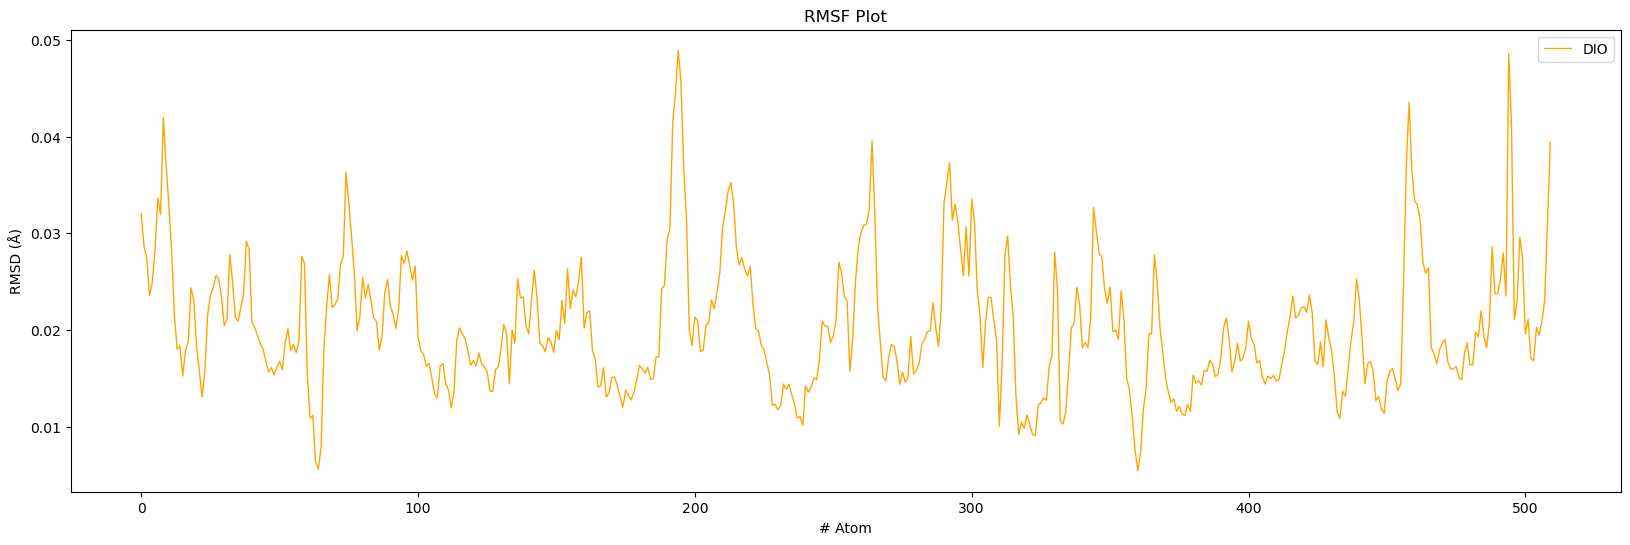

In [25]:
plot_rmsf_difference(original_traj_npy_file=input_train_npy_path,
                                              mutated_reconstructed_traj_npy_file=output_reconstructed_train_npy_path)

#### **APO vs HOLO: Study Dynamic Behavior**

**Apply Model to HOLO structure**

In [ ]:
# Output files
output_reconstructed_data_npy_path = "reconstructed_data.npy"
output_latent_space_npy_path = "latent_space.npy"

prop = {
    "num_layers": nlayers
}

biobb_pytorch.mdae.apply_mdae.applyMDAE(input_data_npy_path=input_data_npy_path,
                                        input_model_pth_path=input_model_pth_path,
                                        output_reconstructed_data_npy_path=output_reconstructed_data_npy_path,
                                        output_latent_space_npy_path=output_latent_space_npy_path,
                                        properties=prop)

**Trajectory Reconstruction RMSD**

In [ ]:
biobb_pytorch.mdae.plots.plot_rmsd(traj_file_npy_path=input_data_npy_path, output_reconstructed_traj_npy_path=output_reconstructed_data_npy_path)

**RMSF**

In [ ]:
plots.plot_rmsf(original_traj_npy_file=input_data_npy_path,
                                   mutated_reconstructed_traj_npy_file=output_reconstructed_data_npy_path)

In [ ]:
plots.plot_rmsf_difference(original_traj_npy_file=input_data_npy_path,
                                              mutated_reconstructed_traj_npy_file=output_reconstructed_data_npy_path)